### Prawler Oxygen Analyis 
Correction to oxy profiles

In [122]:
from erddapy import ERDDAP
import pandas as pd
import numpy as np

server_url = 'http://downdraft.pmel.noaa.gov:8080/erddap'

e = ERDDAP(server=server_url)

df = pd.read_csv(e.get_search_url(response='csv', search_for='PRAWLER'))

print('We have {} tabledap, {} griddap, and {} wms endpoints.'.format(
    len(set(df['tabledap'].dropna())),
    len(set(df['griddap'].dropna())),
    len(set(df['wms'].dropna()))
))

prawlers = df['Dataset ID'].values
print(prawlers)

We have 11 tabledap, 0 griddap, and 0 wms endpoints.
['erddap_4fd3_fb30_b89f' 'erddap_17bsitae_prawler'
 'erddap_17ckitaem2a_prawler' 'erddap_18bsitaepr2a_prawler'
 'erddap_18mtitaepr1a_prawler' 'erddap_19bsitaepr2a_prawler'
 'erddap_19CKitaepr2a_prawler' 'erddap_17ckitaem2a_met'
 'erddap_18bsitaepr2a_met' 'erddap_18mtitaepr1a_met'
 'erddap_19bsitaepr2a_met']


### retrieving and plotting data

In [22]:
d = ERDDAP(server=server_url,
           protocol='tabledap',
           response='csv',
          )

d.dataset_id='erddap_19bsitaepr2a_prawler'

d.variables =  [
 'profile_id',
 'Temperature',
 'Salinity',
 'Chlorophyll',
 'Turbidity',
 'latitude',
 'longitude',
 'depth',
 "time",
 'Oxy_Conc',
 'Oxy_Sat'
]

d.constraints = {
    'time>=': '2018-01-01T00:00:00Z',
    'time<=': '2020-10-10T00:00:00Z',
}

In [124]:
df = d.to_pandas(
    index_col='time (UTC)',
    parse_dates=True,
    skiprows=(1,)  # units information can be dropped.
).dropna()

df.sort_values(by='profile_id',inplace=True)
df.columns = [x[1].split()[0] for x in enumerate(df.columns)]

df.tail()

,profile_id,Temperature,Salinity,Chlorophyll,Turbidity,latitude,longitude,depth,Oxy_Conc,Oxy_Sat
time (UTC),,,,,,,,,,
2019-09-20 20:09:56+00:00,4239,11.553,31.585400,1.5860,9.4848,56.873,-164.065,13.85,288.18567,105.862090
2019-09-20 20:10:04+00:00,4239,11.553,31.584879,1.5128,2.5441,56.873,-164.065,15.13,287.66490,105.670395
2019-09-20 20:10:12+00:00,4239,11.553,31.586510,1.5738,3.5074,56.873,-164.065,15.90,287.90870,105.761185
2019-09-20 20:09:16+00:00,4239,11.551,31.584457,1.7812,3.8532,56.873,-164.065,8.42,289.53815,106.353700
2019-09-20 20:12:44+00:00,4239,5.185,31.862043,0.4758,15.0176,56.873,-164.065,47.52,240.54608,76.781070


In [17]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import YearLocator, WeekdayLocator, MonthLocator, DayLocator, HourLocator, DateFormatter
import matplotlib.ticker as ticker

import cmocean

### specify primary bulk figure parameters
fontsize = 10
labelsize = 10
#plotstyle = 'seaborn'
max_xticks = 10
plt.style.use('seaborn-ticks')
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['ps.fonttype'] = 42 #truetype/type2 fonts instead of type3
mpl.rcParams['pdf.fonttype'] = 42 #truetype/type2 fonts instead of type3
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.edgecolor'] = 'black'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.labelcolor'] = 'black'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['xtick.major.size'] = 4
mpl.rcParams['xtick.minor.size'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.width'] = 0.5
mpl.rcParams['ytick.major.size'] = 4
mpl.rcParams['ytick.minor.size'] = 2
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.width'] = 0.5
mpl.rcParams['ytick.direction'] = 'out'
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.color'] = 'black'
mpl.rcParams['xtick.color'] = 'black'

In [125]:
dfsg = df.groupby('profile_id')

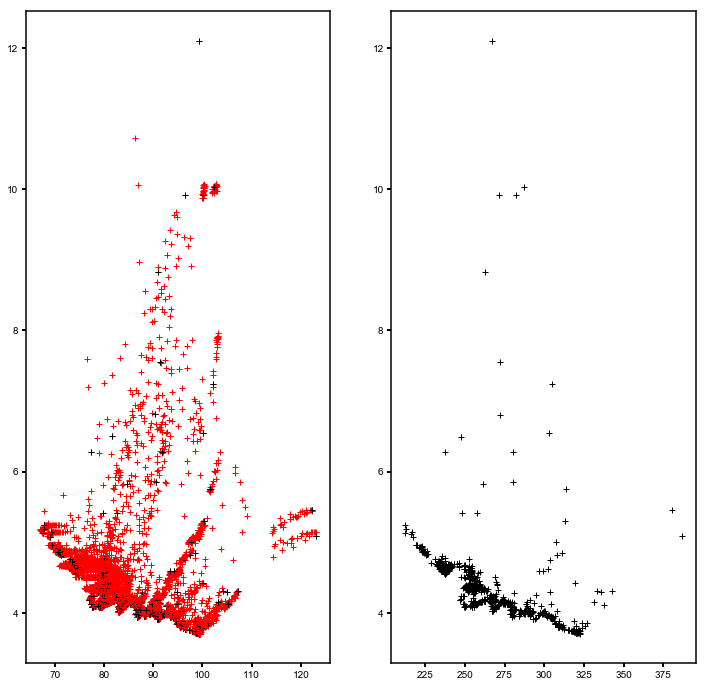

In [6]:
fig, ax = plt.subplots(1,2,figsize=(12, 12))
mld = pd.DataFrame(columns=['MixedLayerDepth','DateTime'])
temp_mld = 0
for i,cast in enumerate(dfsg.groups):
    if dfsg.get_group(cast)['depth'].std() > 1:
        temp_mld = dfsg.get_group(cast)['depth'][(dfsg.get_group(cast)['Temperature'].diff() / dfsg.get_group(cast)['depth'].diff()).idxmin()]
        mld = mld.append({'MixedLayerDepth':temp_mld,
                   'DateTime': (dfsg.get_group(cast)['Temperature'].diff() / dfsg.get_group(cast)['depth'].diff()).idxmin()},
                   ignore_index=True)
    if (dfsg.get_group(cast)['depth'].std() < 1) and (dfsg.get_group(cast)['depth'].median() > temp_mld) and (temp_mld > 15):
        cs = ax[0].plot(dfsg.get_group(cast)['Oxy_Sat'],dfsg.get_group(cast)['Temperature'],'r+')
        cs = ax[0].plot(dfsg.get_group(cast)['Oxy_Sat'].last('s'),dfsg.get_group(cast)['Temperature'].last('s'),'k+')
        cs = ax[1].plot(dfsg.get_group(cast)['Oxy_Conc'].last('s'),dfsg.get_group(cast)['Temperature'].last('s'),'k+')
        


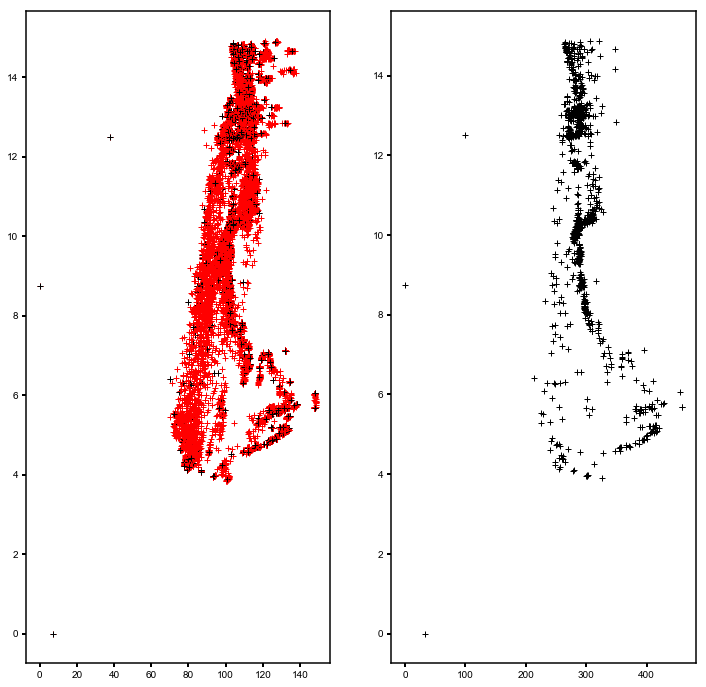

In [7]:
fig, ax = plt.subplots(1,2,figsize=(12, 12))
mld = pd.DataFrame(columns=['MixedLayerDepth','DateTime'])
temp_mld = 0
for i,cast in enumerate(dfsg.groups):
    if dfsg.get_group(cast)['depth'].std() > 1:
        temp_mld = dfsg.get_group(cast)['depth'][(dfsg.get_group(cast)['Temperature'].diff() / dfsg.get_group(cast)['depth'].diff()).idxmin()]
        mld = mld.append({'MixedLayerDepth':temp_mld,
                   'DateTime': (dfsg.get_group(cast)['Temperature'].diff() / dfsg.get_group(cast)['depth'].diff()).idxmin()},
                   ignore_index=True)
    if (dfsg.get_group(cast)['depth'].std() < 1) and (dfsg.get_group(cast)['depth'].median() < temp_mld) and (temp_mld > 15):
        cs = ax[0].plot(dfsg.get_group(cast)['Oxy_Sat'],dfsg.get_group(cast)['Temperature'],'r+')
        cs = ax[0].plot(dfsg.get_group(cast)['Oxy_Sat'].last('s'),dfsg.get_group(cast)['Temperature'].last('s'),'k+')
        cs = ax[1].plot(dfsg.get_group(cast)['Oxy_Conc'].last('s'),dfsg.get_group(cast)['Temperature'].last('s'),'k+')
        


/Users/bell/anaconda2/envs/py37/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


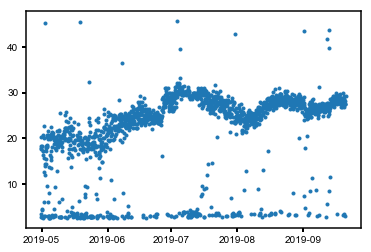

In [8]:
plt.plot(mld.DateTime,mld.MixedLayerDepth,'.')

In [9]:
dfsg.get_group(cast).columns

Index(['profile_id', 'Temperature', 'Salinity', 'Chlorophyll', 'Turbidity',
       'latitude', 'longitude', 'depth', 'Oxy_Conc', 'Oxy_Sat'],
      dtype='object')

In [13]:
print('ProfileID, Time, Oxy_Sat, Temperature, Depth')
for i,cast in enumerate(dfsg.groups):
    if dfsg.get_group(cast)['depth'].std() < 1:
        print(f"{dfsg.get_group(cast)['profile_id'].last('s').values[0]},{dfsg.get_group(cast).index[-1]},{dfsg.get_group(cast)['Oxy_Sat'].last('s').values[0]},\
{dfsg.get_group(cast)['Temperature'].last('s').values[0]},{dfsg.get_group(cast)['depth'].last('s').values[0]}")

ProfileID, Time, Oxy_Sat, Temperature, Depth
18bsitaepr2a_p0003,2018-05-01 20:56:09+00:00,98.703804,3.707,5.6
18bsitaepr2a_p0004,2018-05-01 21:01:24+00:00,98.74368,3.7310000000000003,10.4
18bsitaepr2a_p0005,2018-05-01 21:11:02+00:00,98.598206,3.698,15.8
18bsitaepr2a_p0006,2018-05-01 21:15:59+00:00,98.46944,3.674,21.4
18bsitaepr2a_p0007,2018-05-01 21:20:50+00:00,98.33516999999999,3.662,26.5
18bsitaepr2a_p0008,2018-05-01 21:30:10+00:00,98.25726,3.658,31.9
18bsitaepr2a_p0009,2018-05-01 21:34:55+00:00,98.20933000000001,3.656,35.7
18bsitaepr2a_p0010,2018-05-01 21:39:39+00:00,98.17359,3.6510000000000002,40.3
18bsitaepr2a_p0012,2018-05-01 22:09:16+00:00,98.928444,3.7689999999999997,5.5
18bsitaepr2a_p0013,2018-05-01 22:14:49+00:00,98.871826,3.722,11.0
18bsitaepr2a_p0014,2018-05-01 22:24:09+00:00,98.718094,3.705,15.7
18bsitaepr2a_p0015,2018-05-01 22:29:18+00:00,98.56235500000001,3.68,21.5
18bsitaepr2a_p0016,2018-05-01 22:34:09+00:00,98.415825,3.674,26.5
18bsitaepr2a_p0017,2018-05-01 22:43:42+00

### Bottom O2 Correction Algorithm

In [26]:
### Algorithm to tease out useful orofiles for oxygen

# Vars needed, Temp, OxySat
# Grid Profile data to 1m
# Grid Cal data to 1m
## time interpolate to make matching gridded data set for cal data with profile data

from netCDF4 import date2num, num2date
import datetime
from scipy import interpolate

### vertically grid data to evenly space gridspoints
# deployment depth has a maximum value - set at 50 generically
interval = 1.0 #m
press_grid = np.arange(0,50,interval) #1m  

In [249]:
def profile(cast,press_grid=np.arange(0,50.25,0.25),fillgaps=True):
    """ For a single profile, take median values
    Linearly interpolate to fillgaps"""
    #skip profile if std of depth is less than 1 - likely a park and hold
    if np.std(dfsg.get_group(cast)['depth']) <= 1.0:
        #calibration profile
        return
    else:
        # full profile
        #initialize profile parameters
        profiledata = {'Salinity': [],
                      'Temperature': [],
                      'Chlorophyll': [],
                      'Turbidity': [],
                      'Oxy_Sat': [],
                      'Oxy_Conc': []}

        profiledata = {
                      'Salinity': [],
                      'Temperature': [],
                      'Oxy_Sat': []}
        #fill variables for each profile, taking the median if multiple values within same depth bin
        # and making NaN if no values
        for pg in press_grid:
            """ Take the median value if multiple samples occur within same depth bin"""
            for parameter in profiledata.keys():
                if not parameter in ['Statistics']:
                    ireg_ind = np.where((dfsg.get_group(cast)['depth'] > pg) & (dfsg.get_group(cast)['depth'] <= pg+interval))
                    profiledata[parameter] = np.hstack((profiledata[parameter], dfsg.get_group(cast)[parameter][ireg_ind[0]].median()))
                else:
                    profiledata['Statistics'] = np.hstack((profiledata['Statistics'], ireg_ind[0].size))

        for parameter in profiledata.keys():
            if fillgaps:
                mask = np.isnan(profiledata[parameter])
                profiledata[parameter][mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), profiledata[parameter][~mask], right=-100000)

        profiledata['datetime'] = dfsg.get_group(cast).index[0].to_pydatetime()
        return(profiledata)

def time_interp(date_min,date_max,dt=1.0/24.0):
    dt_min = date2num(date_min -datetime.timedelta(seconds=60*date_min.minute + date_min.second),'Days since 0001-1-1')
    time_grid = np.arange(dt_min,date2num(date_max,'Days since 0001-1-1'),dt) #grid limits -> set to top of hour
    
    return(time_grid)

In [250]:
#full profile data has std>3, park and hold is std<3
profiledata_filled = {}

for profileid in list(dfsg.groups.keys()):
    try:
        if profileid.endswith('00'):
            print("{profileid} of {number}".format(profileid=profileid, number=list(dfsg.groups.keys())[-1]))
    except:
        if (profileid % 100) == 0:
            print("{profileid} of {number}".format(profileid=profileid, number=list(dfsg.groups.keys())[-1]))

    tmp = profile(profileid,press_grid=press_grid)
    if tmp:
        profiledata_filled.update({profileid: tmp})
        

200 of 4239
300 of 4239
400 of 4239
500 of 4239
600 of 4239
700 of 4239
800 of 4239
900 of 4239
1000 of 4239
1100 of 4239
1200 of 4239
1300 of 4239
1400 of 4239
1500 of 4239
1600 of 4239
1700 of 4239
1800 of 4239
1900 of 4239
2000 of 4239
2100 of 4239
2200 of 4239
2300 of 4239
2400 of 4239
2500 of 4239
2600 of 4239
2700 of 4239
2800 of 4239
2900 of 4239
3000 of 4239
3100 of 4239
3200 of 4239
3300 of 4239
3400 of 4239
3500 of 4239
3600 of 4239
3700 of 4239
3800 of 4239
3900 of 4239
4000 of 4239
4100 of 4239
4200 of 4239


In [251]:
parameter='Salinity'
np2d=[]
np2d = [np2d + list(v[parameter]) for k,v in profiledata_filled.items()]


time_grid = time_interp(profiledata_filled[list(profiledata_filled.keys())[0]]['datetime'],
                        profiledata_filled[list(profiledata_filled.keys())[-1]]['datetime'])

date_time = [date2num(v['datetime'],'Days since 0001-1-1') for k,v in profiledata_filled.items()]

#has to be monotonic in time... check if not working that this is true
mono_ind = np.append(True,np.diff(date_time) >0)
date_time=np.array(date_time)[mono_ind]
np2d=np.array(np2d)[mono_ind,:]

mesh_grid_func = interpolate.interp2d(press_grid,date_time,np.array(np2d),kind='linear',bounds_error=False,fill_value=-100000)
mesh_grid_OxySat = mesh_grid_func(press_grid,time_grid)


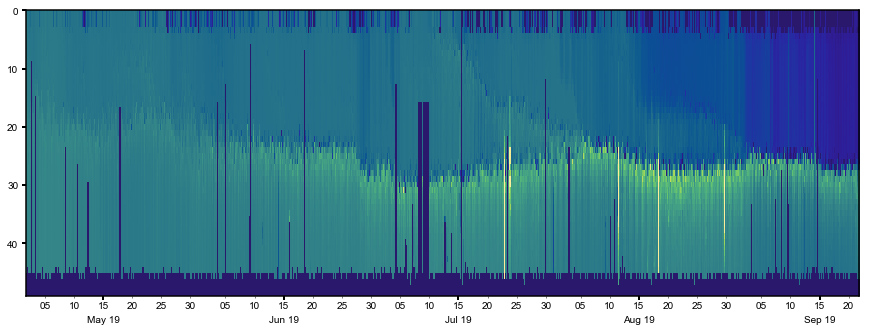

In [255]:
extent = (time_grid.min(),
          time_grid.max(), 
          press_grid.max(), 
          press_grid.min()) # extent of the plots

fig = plt.figure(figsize=(22,5.25))
ax = plt.subplot(1,1,1)
cs = plt.imshow(mesh_grid_OxySat.T,extent=extent, vmin=75, vmax=150, cmap=cmocean.cm.oxy)
cs = plt.imshow(mesh_grid_OxySat.T,extent=extent, vmin=31.5, vmax=32.5, cmap=cmocean.cm.haline)
ax.xaxis.set_major_locator(DayLocator(bymonthday=15))
ax.xaxis.set_minor_locator(DayLocator(bymonthday=[5,10,15,20,25,30]))
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.xaxis.set_minor_formatter(DateFormatter('%d'))
ax.xaxis.set_major_formatter(DateFormatter('%b %y'))
ax.xaxis.set_tick_params(which='major', pad=15)


In [256]:
# Calvin Cleaned the park and hold data I sent from ERDDAP... use to create

import pandas as pd

df_ph = pd.read_excel('/Users/bell/Desktop/AMSS 2020/Stop_Hold_O2sat_V2.xlsx', 
                      parse_dates=True, 
                      sheet_name='19bsitaepr2a_parkandhold_lastva', 
                      index_col='Time')

In [257]:
df_phsg = df_ph.groupby('Calibration Cast')

In [258]:
caldata_filled = {}
fillgaps=True
for profileid in list(df_phsg.groups.keys()):
    ###
    # full profile
    #initialize profile parameters
    profiledata = {
                    ' Salinity': [],
                    ' Temperature': [],
                    ' Oxy_Sat': []}
    #fill variables for each profile, taking the median if multiple values within same depth bin
    # and making NaN if no values
    for pg in press_grid:
        """ Take the median value if multiple samples occur within same depth bin"""
        for parameter in profiledata.keys():
            if not parameter in ['Statistics']:
                ireg_ind = np.where((df_phsg.get_group(profileid)[' Depth'] > pg) & (df_phsg.get_group(profileid)[' Depth'] <= pg+interval))
                profiledata[parameter] = np.hstack((profiledata[parameter], df_phsg.get_group(profileid)[parameter][ireg_ind[0]].median()))
            else:
                profiledata['Statistics'] = np.hstack((profiledata['Statistics'], ireg_ind[0].size))

    for parameter in profiledata.keys():
        if fillgaps:
            mask = np.isnan(profiledata[parameter])
            profiledata[parameter][mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), profiledata[parameter][~mask], right=-100000)

    profiledata['datetime'] = df_phsg.get_group(profileid).index[0].to_pydatetime()
    ###
    caldata_filled.update({profileid: profiledata})

In [259]:
parameter=' Salinity'
np2d=[]
np2d = [np2d + list(v[parameter]) for k,v in caldata_filled.items()]

time_grid = time_interp(caldata_filled[list(caldata_filled.keys())[0]]['datetime'],
                        caldata_filled[list(caldata_filled.keys())[-1]]['datetime'])

date_time = [date2num(v['datetime'],'Days since 0001-1-1') for k,v in caldata_filled.items()]

mesh_grid_func = interpolate.interp2d(press_grid,date_time,np.array(np2d),kind='linear',bounds_error=False,fill_value=-100000)
mesh_grid_OxyConc_ph = mesh_grid_func(press_grid,time_grid)

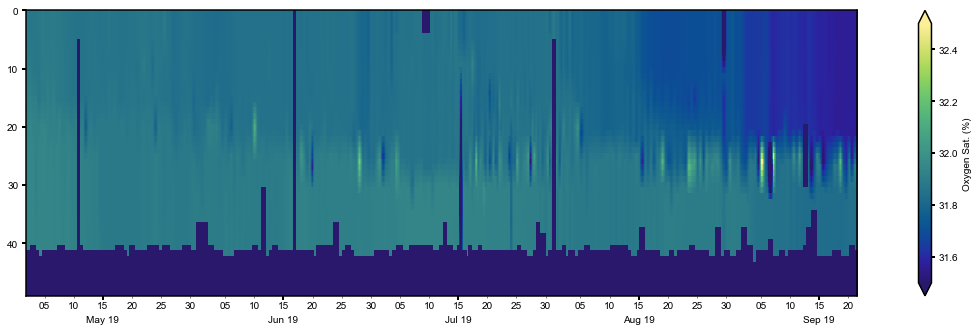

In [261]:
extent = (time_grid.min(),
          time_grid.max(), 
          press_grid.max(), 
          press_grid.min()) # extent of the plots

fig = plt.figure(figsize=(22,5.25))
ax = plt.subplot(1,1,1)
cs = plt.imshow(mesh_grid_OxyConc_ph.T,extent=extent, vmin=75, vmax=150, cmap=cmocean.cm.oxy,label='oxy')
cs = plt.imshow(mesh_grid_OxyConc_ph.T,extent=extent, vmin=31.5, vmax=32.5, cmap=cmocean.cm.haline)

cbar = fig.colorbar(cs, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Oxygen Sat. (%)')
ax.xaxis.set_major_locator(DayLocator(bymonthday=15))
ax.xaxis.set_minor_locator(DayLocator(bymonthday=[5,10,15,20,25,30]))
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.xaxis.set_minor_formatter(DateFormatter('%d'))
ax.xaxis.set_major_formatter(DateFormatter('%b %y'))
ax.xaxis.set_tick_params(which='major', pad=15)


In [262]:
np.shape(mesh_grid_OxyConc_ph)

(3426, 50)

In [263]:
np.shape(mesh_grid_OxySat[:3426,:])

(3426, 50)

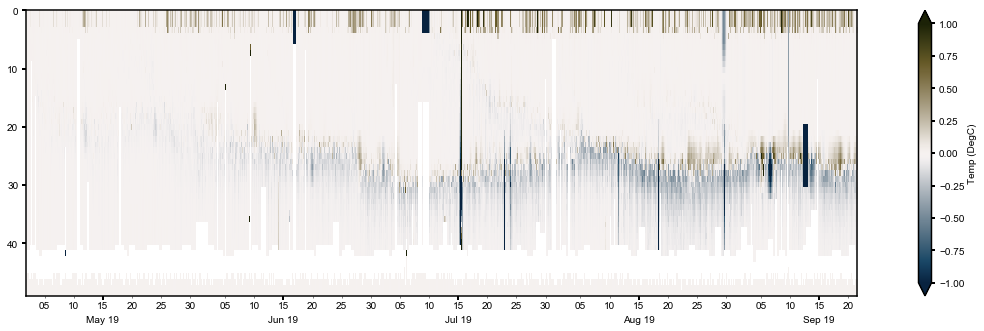

In [265]:
oxydiff = mesh_grid_OxyConc_ph-mesh_grid_OxySat[:3426,:]
oxydiff[np.abs(oxydiff)>1000] = np.nan

extent = (time_grid.min(),
          time_grid.max(), 
          press_grid.max(), 
          press_grid.min()) # extent of the plots

fig = plt.figure(figsize=(22,5.25))
ax = plt.subplot(1,1,1)
cs = plt.imshow((oxydiff).T,extent=extent, vmin=-1,vmax=1,cmap=cmocean.cm.diff,label='oxy')

cbar = fig.colorbar(cs, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Oxygen Sat. (%)')
cbar.ax.set_ylabel('Temp (DegC)')
cbar.ax.set_ylabel('Sal (PSU)')

ax.xaxis.set_major_locator(DayLocator(bymonthday=15))
ax.xaxis.set_minor_locator(DayLocator(bymonthday=[5,10,15,20,25,30]))
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.xaxis.set_minor_formatter(DateFormatter('%d'))
ax.xaxis.set_major_formatter(DateFormatter('%b %y'))
ax.xaxis.set_tick_params(which='major', pad=15)
